In [1]:
import os, time, itertools, imageio, pickle, random
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data

import matplotlib.pyplot as plt
import math
%matplotlib inline

In [2]:
def viz_grid(Xs, padding):
    N, H, W, C = Xs.shape
    grid_size = int(math.ceil(math.sqrt(N)))
    grid_height = H * grid_size + padding * (grid_size + 1)
    grid_width = W * grid_size + padding * (grid_size + 1)
    grid = np.zeros((grid_height, grid_width, C))
    next_idx = 0
    y0, y1 = padding, H + padding
    for y in range(grid_size):
        x0, x1 = padding, W + padding
        for x in range(grid_size):
            if next_idx < N:
                img = Xs[next_idx]
                grid[y0:y1, x0:x1] = img
                next_idx += 1
            x0 += W + padding
            x1 += W + padding
        y0 += H + padding
        y1 += H + padding
    return grid

def set_seed(seed):
    np.random.seed(seed)
    tf.random.set_random_seed(seed)

def conv2d(input, kernel_size, stride, num_filter, name = 'conv2d'):
    with tf.variable_scope(name):
        stride_shape = [1, stride, stride, 1]
        filter_shape = [kernel_size, kernel_size, input.get_shape()[3], num_filter]

        W = tf.get_variable('w', filter_shape, tf.float32, tf.random_normal_initializer(0.0, 0.02))
        b = tf.get_variable('b', [1, 1, 1, num_filter], initializer = tf.constant_initializer(0.0))
        return tf.nn.conv2d(input, W, stride_shape, padding = 'SAME') + b

def conv2d_transpose(input, kernel_size, stride, num_filter, name = 'conv2d_transpose'):
    with tf.variable_scope(name):
        stride_shape = [1, stride, stride, 1]
        filter_shape = [kernel_size, kernel_size, num_filter, input.get_shape()[3]]
        output_shape = tf.stack([tf.shape(input)[0], tf.shape(input)[1] * 2, tf.shape(input)[2] * 2, num_filter])

        W = tf.get_variable('w', filter_shape, tf.float32, tf.random_normal_initializer(0.0, 0.02))
        b = tf.get_variable('b', [1, 1, 1, num_filter], initializer = tf.constant_initializer(0.0))
        return tf.nn.conv2d_transpose(input, W, output_shape, stride_shape, padding = 'SAME') + b

def fc(input, num_output, name = 'fc'):
    with tf.variable_scope(name):
        num_input = input.get_shape()[1]
        W = tf.get_variable('w', [num_input, num_output], tf.float32, tf.random_normal_initializer(0.0, 0.02))
        b = tf.get_variable('b', [num_output], initializer = tf.constant_initializer(0.0))
        return tf.matmul(input, W) + b

def batch_norm(input, is_training):
    out = tf.contrib.layers.batch_norm(input, decay = 0.99, center = True, scale = True,
                                       is_training = is_training, updates_collections = None)
    return out

def leaky_relu(input, alpha = 0.2):
    return tf.maximum(alpha * input, input)

In [3]:
def unpickle(file):
    import sys
    if sys.version_info.major == 2:
        import cPickle
        with open(file, 'rb') as fo:
            dict = cPickle.load(fo)
        return dict['data'], dict['labels']
    else:
        import pickle
        with open(file, 'rb') as fo:
            dict = pickle.load(fo, encoding='bytes')
        return dict[b'data'], dict[b'labels']

def load_train_data():
    X = []
    Y = []
    for i in range(5):
        X_, Y_ = unpickle('data/cifar-10-batches-py/data_batch_%d' % (i + 1))
        X.append(X_)
        Y.extend(Y_)
    X = np.concatenate(X)
    X = X.reshape((X.shape[0], 3, 32, 32)).transpose(0, 2, 3, 1)
    return X, Y

def load_test_data():
    X_, Y = unpickle('data/cifar-10-batches-py/test_batch')
    X = X_.reshape((X_.shape[0], 3, 32, 32)).transpose(0, 2, 3, 1)
    return X, Y

def one_hot_encode(x):
    """
        argument
            - x: a list of labels
        return
            - one hot encoding matrix (number of labels, number of class)
    """
    encoded = np.zeros((len(x), 10))
    
    for idx, val in enumerate(x):
        encoded[idx][val] = 1
    
    return encoded

# Load cifar-10 data
train_samples, train_labels= load_train_data() 
test_samples, test_labels = load_test_data()

train_samples = train_samples/255.0
test_samples = test_samples/255.0
train_labels = one_hot_encode(train_labels)
test_labels = one_hot_encode(test_labels)

In [13]:
class DCGAN(object):

    def __init__(self):
        self.num_epoch = 5
        self.batch_size = 32 #32 => 64
        self.log_step = 50
        self.visualize_step = 200
        self.code_size = 64
        self.learning_rate = 1e-4
        self.vis_learning_rate = 1e-2
        self.recon_steps = 100
        self.actmax_steps = 100
        self.img_size = 32
        
        self._dis_called = False
        self._gen_called = False

        self.tracked_noise = np.random.normal(0, 1, [64, self.code_size])
        self.tracked_label = np.delete(np.transpose(np.tile(np.eye(10), 7)), np.s_[-6:], 0)

        self.real_input = tf.placeholder(tf.float32,
                                         [None, self.img_size, self.img_size, 3])
        self.real_label = tf.placeholder(tf.float32, [None, 1])
        self.fake_label = tf.placeholder(tf.float32, [None, 1])
        self.condition_label = tf.placeholder(tf.float32, [None, 10])
        self.noise = tf.placeholder(tf.float32, [None, self.code_size])
        
        self.is_train = tf.placeholder(tf.bool)
        
        self.recon_sample = tf.placeholder(tf.float32, [1, self.img_size, self.img_size, 3])
        self.actmax_label = tf.placeholder(tf.float32, [1, 1])
        
        with tf.variable_scope('actmax'):
            self.actmax_code = tf.get_variable('actmax_code', [1, self.code_size],
                                               initializer = tf.constant_initializer(0.0))
        
        self._init_ops()

    def _discriminator(self, input, y_fill):
        # We have multiple instances of the discriminator in the same computation graph,
        # so set variable sharing if this is not the first invocation of this function.
        
        # input:(?, self.img_size=32, self.img_size=32, 3)
        # c_label (?, 10) one hot
        # y_fill: (?, 32, 32, 10) label one hot (y_i = 4,then y_fill_i =(i, :, :, 4) =1
        
        
        with tf.variable_scope('dis', reuse = self._dis_called):
            self._dis_called = True
            
            dis_cat = tf.concat([input, y_fill], -1)
            dis_conv1 = conv2d(dis_cat, 4, 2, 32, 'conv1')
            dis_lrelu1 = leaky_relu(dis_conv1)
            dis_conv2 = conv2d(dis_lrelu1, 4, 2, 64, 'conv2')
            dis_batchnorm2 = batch_norm(dis_conv2, self.is_train)
            dis_lrelu2 = leaky_relu(dis_batchnorm2)
            dis_conv3 = conv2d(dis_lrelu2, 4, 2, 128, 'conv3')
            dis_batchnorm3 = batch_norm(dis_conv3, self.is_train)
            dis_lrelu3 = leaky_relu(dis_batchnorm3)
            dis_reshape3 = tf.reshape(dis_lrelu3, [-1, 4 * 4 * 128])
            dis_fc4 = fc(dis_reshape3, 1, 'fc4')
            return dis_fc4

    def _generator(self, input, c_label):
        # input (?, self.code_size=64)
        # c_label (?, 10) one hot

        with tf.variable_scope('gen', reuse = self._gen_called):
            self._gen_called = True
            gen_cat = tf.concat([input, c_label], 1)
            
            gen_fc1 = fc(gen_cat, 4 * 4 * 128, 'fc1')
            gen_reshape1 = tf.reshape(gen_fc1, [-1, 4, 4, 128])
            gen_batchnorm1 = batch_norm(gen_reshape1, self.is_train)
            gen_lrelu1 = leaky_relu(gen_batchnorm1)
            gen_conv2 = conv2d_transpose(gen_lrelu1, 4, 2, 64, 'conv2')
            gen_batchnorm2 = batch_norm(gen_conv2, self.is_train)
            gen_lrelu2 = leaky_relu(gen_batchnorm2)
            gen_conv3 = conv2d_transpose(gen_lrelu2, 4, 2, 32, 'conv3')
            gen_batchnorm3 = batch_norm(gen_conv3, self.is_train)
            gen_lrelu3 = leaky_relu(gen_batchnorm3)
            gen_conv4 = conv2d_transpose(gen_lrelu3, 4, 2, 3, 'conv4')
            gen_sigmoid4 = tf.sigmoid(gen_conv4)
            return gen_sigmoid4
        
        
    def _loss(self, labels, logits):
        loss = tf.nn.sigmoid_cross_entropy_with_logits(labels = labels, logits = logits)
        return tf.reduce_mean(loss)

    def _reconstruction_loss(self, generated, target):
        loss = tf.nn.l2_loss(generated - target)
        return tf.reduce_mean(loss)

    def _loss(self, labels, logits):
        loss = tf.nn.sigmoid_cross_entropy_with_logits(labels = labels, logits = logits)
        return tf.reduce_mean(loss)

    def _reconstruction_loss(self, generated, target):
        loss = tf.nn.l2_loss(generated - target)
        return tf.reduce_mean(loss)
    
    # Define operations
    def _init_ops(self):
        
        ################################################################################
        # Prob 2-1: complete the definition of these operations                        #
        ################################################################################
        # reshape
        y_label_ = tf.reshape(self.condition_label, [-1, 1, 1, 10])
        bsize = tf.shape(self.condition_label)[0]
        y_fill_ = y_label_ * tf.ones([bsize, self.img_size, self.img_size, 10])
        
        # self.fake_samples_op = None
        self.fake_samples_op = self._generator(self.noise, self.condition_label)
        
        self.dis_loss_op = self._loss(self.real_label, 
                                      self._discriminator(self.real_input, y_fill_)
                                      ) + self._loss(self.fake_label,
            self._discriminator(self.fake_samples_op, y_fill_))
        
        # self.gen_loss_op = None
        self.gen_loss_op = self._loss(self.real_label,
                                      self._discriminator(self.fake_samples_op, y_fill_))
        
        ################################################################################
        # Prob 2-1: fix the definition of these operations                             #
        ################################################################################
        
        # dis_optimizer = tf.train.RMSPropOptimizer(self.learning_rate)
        # self.dis_train_op = dis_optimizer.minimize(self.dis_loss_op)
        dis_train_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,
                                     "dis")
        dis_optimizer = tf.train.RMSPropOptimizer(self.learning_rate)
        self.dis_train_op = dis_optimizer.minimize(self.dis_loss_op,
                                                   var_list=dis_train_vars)
        
        # gen_optimizer = tf.train.RMSPropOptimizer(self.learning_rate)
        # self.gen_train_op = gen_optimizer.minimize(self.gen_loss_op)
        gen_train_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,
                                     "gen")
        gen_optimizer = tf.train.RMSPropOptimizer(self.learning_rate)
        self.gen_train_op = gen_optimizer.minimize(self.gen_loss_op,
                                                  var_list=gen_train_vars)
        
        ################################################################################
        # Prob 2-4: check the definition of these operations                           #
        # skip this part when working on problem 2-1 and come back for problem 2-4     #
        ################################################################################
        
        self.actmax_sample_op = self._generator(self.actmax_code, self.condition_label)
        actmax_dis = self._discriminator(self.actmax_sample_op, y_fill_)
        self.actmax_loss_op = self._loss(self.actmax_label, actmax_dis)

        actmax_optimizer = tf.train.AdamOptimizer(self.vis_learning_rate)
        self.actmax_op = actmax_optimizer.minimize(self.actmax_loss_op, var_list = [self.actmax_code])
        
        ################################################################################
        # Prob 2-4: complete the definition of these operations                        #
        # skip this part when working on problem 2-1 and come back for problem 2-4     #
        ################################################################################
        
        # self.recon_loss_op = None
        self.recon_loss_op = self._reconstruction_loss(self.actmax_sample_op, self.recon_sample)
        
        # recon_optimizer = tf.train.AdamOptimizer(self.vis_learning_rate)
        recon_optimizer = tf.train.AdamOptimizer(self.vis_learning_rate)
        
        # self.reconstruct_op = recon_optimizer.minimize(self.recon_loss_op)
        self.reconstruct_op = recon_optimizer.minimize(self.recon_loss_op)
        
        
        ################################################################################
        #                               END OF YOUR CODE                               #
        ################################################################################

    # Training function
    def train(self, sess, train_samples, test_labels):
        sess.run(tf.global_variables_initializer())

        num_train = train_samples.shape[0]
        step = 0
        
        # smooth the loss curve so that it does not fluctuate too much
        smooth_factor = 0.95
        plot_dis_s = 0
        plot_gen_s = 0
        plot_ws = 0
        
        dis_losses = []
        gen_losses = []
        max_steps = int(self.num_epoch * (num_train // self.batch_size))
        print('Start training ...')
        for epoch in range(self.num_epoch):
            for i in range(num_train // self.batch_size):
                step += 1

                batch_samples = train_samples[i * self.batch_size : (i + 1) * self.batch_size]
                batch_labels = train_labels[i * self.batch_size : (i + 1) * self.batch_size]
                #noise = np.random.normal(0, 1, [batch_labels.shape[0], self.code_size])
                noise = np.random.normal(0, 1, [self.batch_size, self.code_size])
                zeros = np.zeros([self.batch_size, 1])
                ones = np.ones([self.batch_size, 1])
        
                ################################################################################
                # Prob 2-1: complete the feed dictionary                                       #
                ################################################################################
                
                # dis_feed_dict = {}
                dis_feed_dict = {self.real_input:batch_samples, self.real_label:zeros,
                                self.fake_label:ones, self.noise:noise, self.is_train:True,
                                self.condition_label:batch_labels}
                
                ################################################################################
                #                               END OF YOUR CODE                               #
                ################################################################################
                #print('batch', batch_labels.shape, 'noise', noise.shape)

                _, dis_loss = sess.run([self.dis_train_op, self.dis_loss_op], feed_dict = dis_feed_dict)
        
                ################################################################################
                # Prob 2-1: complete the feed dictionary                                       #
                ################################################################################
                
                # gen_feed_dict = {}
                gen_feed_dict = {self.noise:noise, self.real_label:zeros,
                                 self.fake_label:ones, self.is_train:True,
                                 self.condition_label:batch_labels}
                
                ################################################################################
                #                               END OF YOUR CODE                               #
                ################################################################################

                _, gen_loss = sess.run([self.gen_train_op, self.gen_loss_op], feed_dict = gen_feed_dict)

                plot_dis_s = plot_dis_s * smooth_factor + dis_loss * (1 - smooth_factor)
                plot_gen_s = plot_gen_s * smooth_factor + gen_loss * (1 - smooth_factor)
                plot_ws = plot_ws * smooth_factor + (1 - smooth_factor)
                dis_losses.append(plot_dis_s / plot_ws)
                gen_losses.append(plot_gen_s / plot_ws)

                if step % self.log_step == 0:
                    print('Iteration {0}/{1}: dis loss = {2:.4f}, gen loss = {3:.4f}'.format(step, max_steps, dis_loss, gen_loss))

            fig = plt.figure(figsize = (8, 8))   
            ax1 = plt.subplot(111)
            ax1.imshow(viz_grid(self.generate(self.tracked_noise), 1))
            plt.show()

            plt.plot(dis_losses)
            plt.title('discriminator loss')
            plt.xlabel('iterations')
            plt.ylabel('loss')
            plt.show()

            plt.plot(gen_losses)
            plt.title('generator loss')
            plt.xlabel('iterations')
            plt.ylabel('loss')
            plt.show()
        print('... Done!')

    # Find the reconstruction of one input sample
    def reconstruct_one_sample(self, sample):
        
        ################################################################################
        # Prob 2-4: initialize self.actmax_code                                        #
        # skip this part when working on problem 2-1 and come back for problem 2-4     #
        ################################################################################
        
        # actmax_init_val = None
        # sample <class 'numpy.ndarray'> (1, 32, 32, 3)
        # sample_tf = tf.convert_to_tensor(sample, dtype = tf.float32)
        actmax_init_val = np.random.normal(0, 1, [1, self.code_size])
        
        self.condition_label = np.eye(10)
        ################################################################################
        #                               END OF YOUR CODE                               #
        ################################################################################
        
        sess.run(self.actmax_code.assign(actmax_init_val))
        last_reconstruction = None
        last_loss = None
        for i in range(self.recon_steps):
        
            ################################################################################
            # Prob 2-4: complete the feed dictionary                                       #
            # skip this part when working on problem 2-1 and come back for problem 2-4     #
            ################################################################################   
            confeed = np.zeros((1,10))
            confeed[i%10] = 1
            
            # recon_feed_dict = {}
            recon_feed_dict = {self.recon_sample: sample, self.actmax_label: np.ones([1, 1]),
                               self.is_train: True, self.condition_label:confeed }
            
            ################################################################################
            #                               END OF YOUR CODE                               #
            ################################################################################
            
            run_ops = [self.recon_loss_op, self.reconstruct_op, self.actmax_sample_op]
            last_loss, _, last_reconstruction = sess.run(run_ops, feed_dict = recon_feed_dict)
        return last_loss, last_reconstruction

    # Find the reconstruction of a batch of samples
    def reconstruct(self, samples):
        reconstructions = np.zeros(samples.shape)
        total_loss = 0
        for i in range(samples.shape[0]):
            loss, reconstructions[i:i+1] = self.reconstruct_one_sample(samples[i:i+1])
            total_loss += loss
        return total_loss / samples.shape[0], reconstructions

    # Generates a single sample from input code
    def generate_one_sample(self, code, label):
        
        ################################################################################
        # Prob 2-1: complete the feed dictionary                                       #
        ################################################################################
        
        # gen_vis_feed_dict = {}
        gen_vis_feed_dict = {self.noise:code, self.is_train:False,
                             self.condition_label:label
                            }
        
        ################################################################################
        #                               END OF YOUR CODE                               #
        ################################################################################
        
        generated = sess.run(self.fake_samples_op, feed_dict = gen_vis_feed_dict)
        return generated

    # Generates samples from input batch of codes
    def generate(self, codes):
        generated = np.zeros((codes.shape[0], 32, 32, 3))
        for i in range(codes.shape[0]):
            generated[i:i+1] = self.generate_one_sample(codes[i:i+1], one_hot_encode([i%10]))
        return generated

    # Perform activation maximization on one initial code
    def actmax_one_sample(self, initial_code):
        
        ################################################################################
        # Prob 2-4: check this function                                                #
        # skip this part when working on problem 2-1 and come back for problem 2-4     #
        ################################################################################
        
        actmax_init_val = tf.convert_to_tensor(initial_code, dtype = tf.float32)
        sess.run(self.actmax_code.assign(actmax_init_val))
        for i in range(self.actmax_steps):
            actmax_feed_dict = {
                self.actmax_label: np.ones([1, 1]),
                self.is_train: False
            }
            _, last_actmax = sess.run([self.actmax_op, self.actmax_sample_op], feed_dict = actmax_feed_dict)
        return last_actmax

    # Perform activation maximization on a batch of different initial codes
    def actmax(self, initial_codes):
        actmax_results = np.zeros((initial_codes.shape[0], 32, 32, 3))
        for i in range(initial_codes.shape[0]):
            actmax_results[i:i+1] = self.actmax_one_sample(initial_codes[i:i+1])
        return actmax_results.clip(0, 1)



In [14]:
def show_result(num_epoch, show = False, save = False, path = 'result.png'):
    test_images = sess.run(G_z, {z: fixed_z_, y_label: fixed_y_, isTrain: False})

    size_figure_grid = 10
    fig, ax = plt.subplots(size_figure_grid, size_figure_grid, figsize=(5, 5))
    for i, j in itertools.product(range(size_figure_grid), range(size_figure_grid)):
        ax[i, j].get_xaxis().set_visible(False)
        ax[i, j].get_yaxis().set_visible(False)

    for k in range(10*10):
        i = k // 10
        j = k % 10
        ax[i, j].cla()
        ax[i, j].imshow(np.reshape(test_images[k], (img_size, img_size)), cmap='gray')

    label = 'Epoch {0}'.format(num_epoch)
    fig.text(0.5, 0.04, label, ha='center')

    if save:
        plt.savefig(path)

    if show:
        plt.show()
    else:
        plt.close()

def show_train_hist(hist, show = False, save = False, path = 'Train_hist.png'):
    x = range(len(hist['D_losses']))

    y1 = hist['D_losses']
    y2 = hist['G_losses']

    plt.plot(x, y1, label='D_loss')
    plt.plot(x, y2, label='G_loss')

    plt.xlabel('Epoch')
    plt.ylabel('Loss')

    plt.legend(loc=4)
    plt.grid(True)
    plt.tight_layout()

    if save:
        plt.savefig(path)

    if show:
        plt.show()
    else:
        plt.close()


Start training ...
Iteration 50/7810: dis loss = 1.1480, gen loss = 0.9069
Iteration 100/7810: dis loss = 0.2259, gen loss = 2.7029
Iteration 150/7810: dis loss = 0.2613, gen loss = 2.3335
Iteration 200/7810: dis loss = 0.4359, gen loss = 1.7150
Iteration 250/7810: dis loss = 0.2572, gen loss = 2.5322
Iteration 300/7810: dis loss = 0.2511, gen loss = 2.4537
Iteration 350/7810: dis loss = 0.6135, gen loss = 3.3139
Iteration 400/7810: dis loss = 1.1179, gen loss = 1.0953
Iteration 450/7810: dis loss = 0.9218, gen loss = 1.0394
Iteration 500/7810: dis loss = 1.0396, gen loss = 0.8669
Iteration 550/7810: dis loss = 0.7456, gen loss = 1.2193
Iteration 600/7810: dis loss = 0.6733, gen loss = 2.1377
Iteration 650/7810: dis loss = 1.3491, gen loss = 2.6037
Iteration 700/7810: dis loss = 0.9584, gen loss = 2.1144
Iteration 750/7810: dis loss = 1.1445, gen loss = 0.9387
Iteration 800/7810: dis loss = 0.6549, gen loss = 1.4227
Iteration 850/7810: dis loss = 1.0767, gen loss = 0.6248
Iteration 900

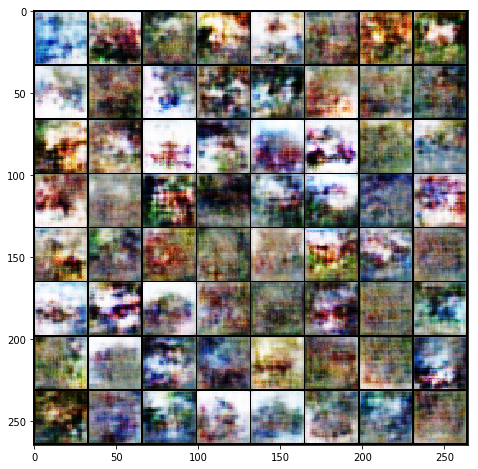

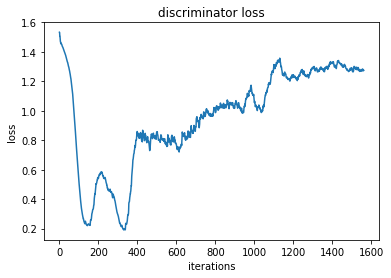

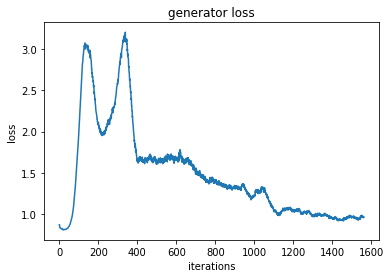

Iteration 1600/7810: dis loss = 1.2203, gen loss = 0.8544
Iteration 1650/7810: dis loss = 1.2221, gen loss = 1.4322
Iteration 1700/7810: dis loss = 1.2153, gen loss = 0.8286
Iteration 1750/7810: dis loss = 1.2790, gen loss = 0.6822
Iteration 1800/7810: dis loss = 1.2464, gen loss = 1.4797
Iteration 1850/7810: dis loss = 1.1336, gen loss = 0.7559
Iteration 1900/7810: dis loss = 0.7617, gen loss = 1.3273


KeyboardInterrupt: 

In [15]:
tf.reset_default_graph()
set_seed(21)

with tf.Session() as sess:
    with tf.device('/cpu:0'):
        dcgan = DCGAN()
        sess.run(tf.global_variables_initializer())
        dcgan.train(sess, train_samples, train_labels)
        dis_var_list = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, 'dis')
        gen_var_list = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, 'gen')
        saver = tf.train.Saver(dis_var_list + gen_var_list)
        saver.save(sess, 'model/dcgan')